In [1]:
import numpy as np
import matplotlib.pyplot as plt

from module.utils import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Slices_VanVAE
This is an exmple of a VAE that is trained on a single mu coefficient slices.
At the end some images are generated and the spectrum is compared with the original one.

## Import data

In [2]:
# Set the directory containing the images
input_directory = 'data'

transform = transforms.Compose([transforms.ToTensor()])

# Create the dataset
dataset = datasets.DatasetFolder(input_directory,  transform=transform,  loader=npy_loader,  extensions=['.npy'])

# Get the class labels and split the dataset into train and test sets
class_labels = dataset.classes
train_dataset, test_dataset = train_test_split(dataset, test_size=0.20, random_state=42)

# Print the number of samples in each split
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

# Create data loaders
batch_size = 24 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 102
Test set size: 26


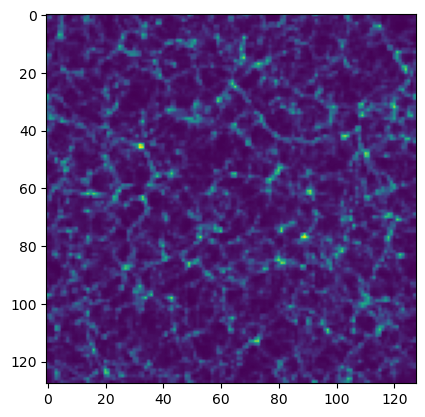

In [3]:
# show one image from the first batch
plt.figure()
plt.imshow(train_dataset[0][0][0])  

## Define and train the model

In [4]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x100x100
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# the latent space is represented by two vectors, mean and logvar, dimension 2

# for the decoder, the latent space is first passed through a linear layer to get a tensor of size 64
# then reshaped to a tensor of size 64x1x1
# then passed through two ConvTranspose2d layers to get the output image
# first have 64 filters and kernel size 4, stride 2, padding 1
# second have 32 filters and kernel size 4, stride 2, padding 1
# the output image is of size 1x100x100

class VAE(torch.nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        self.fc1 = torch.nn.Linear(64*32*32, latent_dim)
        self.fc2 = torch.nn.Linear(64*32*32, latent_dim)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64*32*32),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (64, 32, 32)),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            torch.nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [5]:
# define the model
latent_dim = 2
model = VAE(latent_dim)

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [6]:
# train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss/len(train_loader.dataset)}')

Epoch 0, Loss 10801.541015625
Epoch 1, Loss 7136.210822610294
Epoch 2, Loss 6668.414177389706
Epoch 3, Loss 6387.399931066177
Epoch 4, Loss 6295.736979166667
Epoch 5, Loss 6170.959214154412
Epoch 6, Loss 6051.347349877451
Epoch 7, Loss 5975.537224264706
Epoch 8, Loss 5913.621783088235
Epoch 9, Loss 5889.874885110294
Epoch 10, Loss 5874.578010110294
Epoch 11, Loss 5858.405292585784
Epoch 12, Loss 5839.229932598039
Epoch 13, Loss 5829.855353860294
Epoch 14, Loss 5820.515701593137
Epoch 15, Loss 5810.484834558823
Epoch 16, Loss 5800.320274203431
Epoch 17, Loss 5793.089958639706
Epoch 18, Loss 5780.347617953431
Epoch 19, Loss 5772.1505438112745
Epoch 20, Loss 5766.317325367647
Epoch 21, Loss 5757.345013786765
Epoch 22, Loss 5752.103056066177
Epoch 23, Loss 5746.682942708333
Epoch 24, Loss 5740.099532781863
Epoch 25, Loss 5733.349954044118
Epoch 26, Loss 5728.821997549019
Epoch 27, Loss 5724.333754595588
Epoch 28, Loss 5721.959520526961
Epoch 29, Loss 5715.1176853553925
Epoch 30, Loss 5710.

In [17]:
# save the model as models/VanVAE.pth
torch.save(model.state_dict(), 'models/VanVAE.pth')

## Analyze the results

### Qualitative production of images

Text(0.5, 1.0, 'Reconstructed Image')

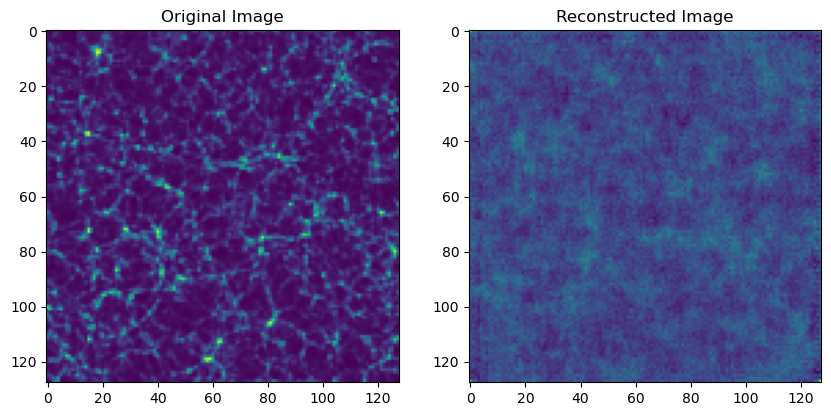

In [7]:
# show the original and reconstructed image for the first test image
model.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        recon_images, _, _ = model(images)
        break
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0][0])
# title
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(recon_images[0][0])
# title
plt.title('Reconstructed Image')

### Latent space analysis

In [8]:
# get points in the latent space of the training set

model.eval()

train_latent = []

with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        _, mu, _ = model(images)
        train_latent.append(mu)
train_latent = torch.cat(train_latent, dim=0)


# get the points in the latent space of the test set
test_latent = []

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        _, mu, _ = model(images)
        test_latent.append(mu)
test_latent = torch.cat(test_latent, dim=0)

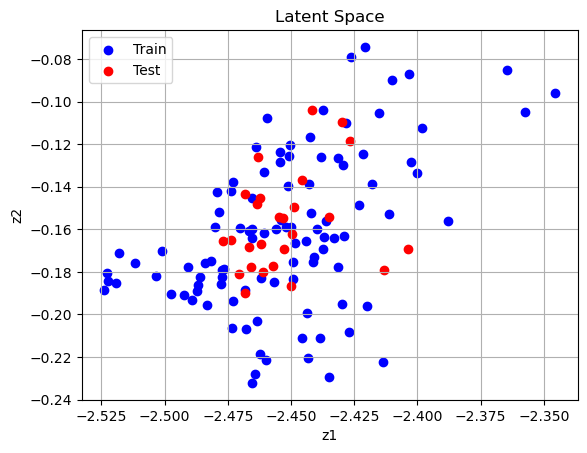

In [9]:
# plot the points in the latent space
plt.figure()
plt.scatter(train_latent[:, 0], train_latent[:, 1], color='b', label='Train')
plt.scatter(test_latent[:, 0], test_latent[:, 1], color='r', label='Test')
plt.legend()
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Latent Space')
plt.grid()

We can see that test images do not have a clear separation in the latent space. This is expected since the model is trained on a single mu coefficient.

### Power spectrum analysis

In [10]:
# get the PS from test images and the PS from reconstructed test images
model_PS = mean_PS_from_dataloader(test_loader, model)
real_PS = mean_PS_from_dataloader(test_loader)

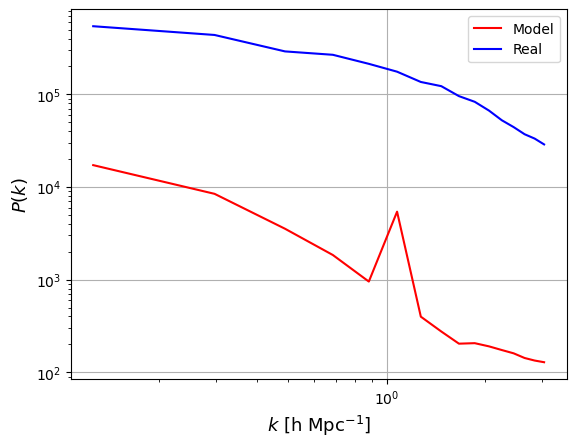

In [15]:
# plot and compare
plt.figure()
plt.plot(model_PS[:, 0], model_PS[:, 1], 'r', label='Model')
plt.plot(real_PS[:, 0], real_PS[:, 1], 'b', label='Real')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$k$ [h $\mathrm{Mpc^{-1}}$]', fontsize = 13)
plt.ylabel(r'$P(k)$', fontsize = 13)
plt.grid()
